# Trabajo Final Analisis Predictivo_Javier Gilabert Sabater

-----

# IMPORTANTE: CAMBIAR NOMBRES TRAIN Y TEST PARA RESERVAS Y CANCELACIONES

# Theta y 4Theta

## Analisis Serie Reservas

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
from darts import TimeSeries
from darts.models import FourTheta
from darts.metrics import mape
from darts.utils.utils import SeasonalityMode, TrendMode, ModelMode

In [44]:
#Lectura
df_w_r = pd.read_csv('df_cancelaciones.csv')
df_w_r['ArrivalDate'] = pd.to_datetime(df_w_r['ArrivalDate'])
df_w_r = df_w_r.set_index('ArrivalDate')
df_w_r.tail()

,IsCanceled
ArrivalDate,
2017-08-06,251
2017-08-13,275
2017-08-20,332
2017-08-27,206
2017-09-03,101


In [45]:
df_w_r_theta = df_w_r.copy()
df_w_r_theta.reset_index(level=0, inplace=True)

df_w_r_ts = TimeSeries.from_dataframe(df_w_r_theta,'ArrivalDate','IsCanceled')
train, test = df_w_r_ts.split_before(pd.Timestamp("20170813"))

In [46]:
test

<TimeSeries (DataArray) (ArrivalDate: 4, component: 1, sample: 1)>
array([[[275.]],

       [[332.]],

       [[206.]],

       [[101.]]])
Coordinates:
  * ArrivalDate  (ArrivalDate) datetime64[ns] 2017-08-13 ... 2017-09-03
  * component    (component) object 'IsCanceled'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [51]:
model_4theta =FourTheta(seasonality_period=12)
model_4theta.fit(train)
matlab_4theta_pred = model_4theta.predict(len(test))
print("model {} obtains MAPE: {:.2f}%".format(model_4theta, mape(test, matlab_4theta_pred)))

model FourTheta(seasonality_period=12) obtains MAPE: 74.92%


Text(0.5, 1.0, 'model 4Theta')

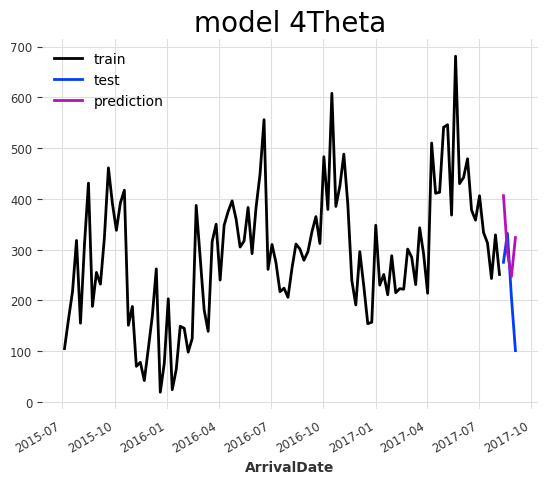

In [52]:
train.plot(label="train")
test.plot(label="test")
matlab_4theta_pred.plot(label="prediction")

plt.title(label="model 4Theta",
          fontsize=20,
          color="black")

In [36]:
fourtheta_grid = {
    'theta':[-4,-3,-2,-1,1,2,3,4],
    'model_mode': [ModelMode.ADDITIVE,ModelMode.MULTIPLICATIVE],
    'season_mode': [SeasonalityMode.MULTIPLICATIVE,SeasonalityMode.ADDITIVE],
    'trend_mode': [TrendMode.EXPONENTIAL,TrendMode.LINEAR]
}

best_grid_model=FourTheta.gridsearch(parameters=fourtheta_grid,
                                series=train,
                                forecast_horizon=4, # 12
                                start=0.85,
                                last_points_only=False,
                                metric=mape,
                                reduction=np.mean,
                                verbose=False,
                                n_jobs=-1)

best_grid_model

(FourTheta(theta=-1, seasonality_period=None, season_mode=SeasonalityMode.ADDITIVE, model_mode=ModelMode.ADDITIVE, trend_mode=TrendMode.EXPONENTIAL, normalization=True),
 {'theta': -1,
  'model_mode': <ModelMode.ADDITIVE: 'additive'>,
  'season_mode': <SeasonalityMode.ADDITIVE: 'additive'>,
  'trend_mode': <TrendMode.EXPONENTIAL: 'exponential'>},
 14.570117872303534)

Text(0.5, 1.0, 'Best 4Theta model')

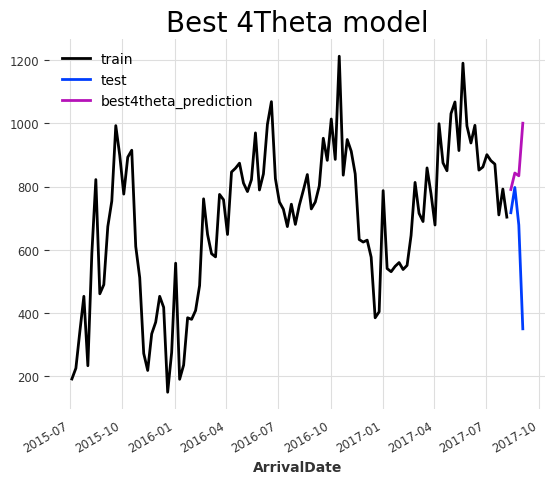

In [37]:
best4Theta_model=FourTheta(theta=best_grid_model[1]['theta'],
                 model_mode=ModelMode.ADDITIVE,
                 season_mode=SeasonalityMode.ADDITIVE,
                 trend_mode=TrendMode.EXPONENTIAL
                 )
best4Theta_model.fit(train)
best4Theta_model_prediction = best4Theta_model.predict(len(test))

train.plot(label="train")
test.plot(label="test")
best4Theta_model_prediction.plot(label="best4theta_prediction")

plt.title(label="Best 4Theta model",
          fontsize=20,
          color="black")

In [38]:
mape(test, best4Theta_model_prediction)

56.4362151508647

In [39]:
from darts.models import TBATS

In [40]:
model_tbats =TBATS(
use_box_cox=None,
box_cox_bounds=(0, 1),
use_trend=None,
use_damped_trend=None,
seasonal_periods="freq",
use_arma_errors=True,
show_warnings=False,
multiprocessing_start_method='spawn',
random_state=0)
model_tbats.fit(train)
prediction_tbats = model_tbats.predict(len(test))

In [41]:
model_tbats.model.params.summary()

'Use Box-Cox: False\nUse trend: False\nUse damped trend: False\nSeasonal periods: []\nSeasonal harmonics []\nARMA errors (p, q): (0, 0)\nSmoothing (Alpha): 0.616109\nSeasonal Parameters (Gamma): []\nAR coefficients []\nMA coefficients []\nSeed vector [495.64260058]\n'

<Axes: xlabel='ArrivalDate'>

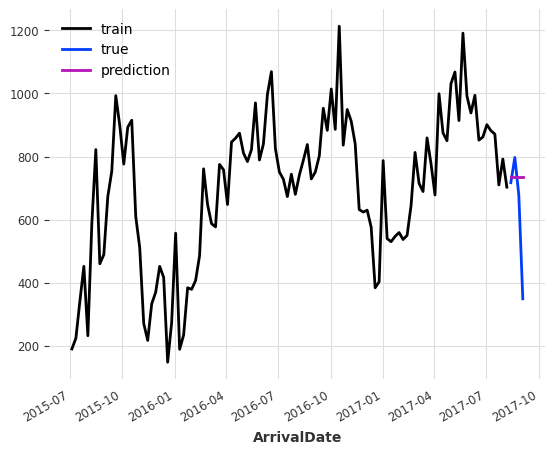

In [42]:
train.plot(label="train")
test.plot(label="true")
prediction_tbats.plot(label="prediction")

In [43]:
tbats = mape(test, prediction_tbats)
tbats

32.270173523547555